<a href="https://colab.research.google.com/github/Al-RaoushBasel/Crime-Data-Analysis/blob/main/crime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crime Data Analysis Notebook

Load Necessary Libraries and Mount Google Drive

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

Mount Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Load Crime Dataset

In [4]:
crime_data = pd.read_csv('/content/drive/My Drive/datasets/cleaned_crime_data_final.csv')
print("Crime Data Loaded Successfully!")
print(crime_data.info())
print(crime_data.head())
print("Missing values:", crime_data.isnull().sum())

Crime Data Loaded Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rank             343 non-null    int64  
 1   City             343 non-null    object 
 2   Crime Index      343 non-null    float64
 3   Safety Index     343 non-null    float64
 4   Country          343 non-null    object 
 5   Continent_x      343 non-null    object 
 6   Population_2022  343 non-null    float64
 7   Area_km2         343 non-null    float64
 8   Density_per_km2  343 non-null    float64
 9   Growth Rate      343 non-null    float64
 10  GDP_2022         343 non-null    float64
 11  GDP_2023         343 non-null    float64
 12  Continent_y      343 non-null    object 
 13  City_Country     343 non-null    object 
 14  Latitude         343 non-null    float64
 15  Longitude        343 non-null    float64
dtypes: float64(10), int64(1), obje

Load Additional Datasets

In [5]:
school_data = pd.read_csv('/content/drive/My Drive/datasets/school_enrollment_data.csv', encoding='cp1252', skiprows=4)
unemployment_data = pd.read_csv('/content/drive/My Drive/datasets/unemployment_rates_data.csv', encoding='cp1252', skiprows=4)
income_data = pd.read_csv('/content/drive/My Drive/datasets/national_income_percapita.csv', encoding='cp1252', skiprows=4)

Check basic information about additional datasets

In [6]:
for name, dataset in zip(["School", "Unemployment", "Income"], [school_data, unemployment_data, income_data]):
    print(f"--- {name} Data ---")
    print(dataset.info())
    print(dataset.head())
    print("Missing values:", dataset.isnull().sum())

--- School Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            82 non-null     float64
 15  1971            162 non-null    float64
 16  1972            151 non-null    float64
 17  1973           

Drop unnecessary columns

In [7]:
cols_to_drop = ['Indicator Name', 'Indicator Code', 'Unnamed: 68']
for dataset in [school_data, unemployment_data, income_data]:
    dataset.drop(columns=[col for col in cols_to_drop if col in dataset.columns], inplace=True)

In [8]:
# Function to fill missing values using the average of last 3 available years
def fill_missing_values(df, target_year):
    for index, row in df.iterrows():
        if pd.isnull(row[target_year]):
            available_years = [row[str(year)] for year in range(int(target_year)-1, int(target_year)-4, -1) if not pd.isnull(row[str(year)])]
            if len(available_years) > 0:
                df.at[index, target_year] = np.mean(available_years)
    return df

Fill missing values

In [9]:
school_data = fill_missing_values(school_data, '2022')
unemployment_data = fill_missing_values(unemployment_data, '2022')
income_data = fill_missing_values(income_data, '2021')

Fill missing values using continent mean

In [10]:
def fill_with_continent_mean(df, main_df, year):
    merged = pd.merge(df, main_df[['Country', 'Continent_x']], left_on='Country Name', right_on='Country', how='left')
    merged = merged.dropna(subset=['Continent_x'])
    continent_means = merged.groupby('Continent_x')[year].mean()
    for index, row in merged.iterrows():
        if pd.isnull(row[year]):
            merged.at[index, year] = continent_means.get(row['Continent_x'], None)
    return merged[['Country Name', 'Country Code', year]]

school_data = fill_with_continent_mean(school_data, crime_data, '2022')
unemployment_data = fill_with_continent_mean(unemployment_data, crime_data, '2022')

In [11]:
# Reload full income dataset for interpolation
full_income_data = pd.read_csv('/content/drive/My Drive/datasets/national_income_percapita.csv', encoding='cp1252', skiprows=4)
full_income_data.drop(columns=[col for col in cols_to_drop if col in full_income_data.columns], inplace=True)

# Perform linear interpolation on income data
numeric_cols = full_income_data.select_dtypes(include=['float64', 'int64']).columns
full_income_data[numeric_cols] = full_income_data[numeric_cols].interpolate(method='linear', axis=1)

# Extract only 2021 income data
time_filtered_income_data = full_income_data[['Country Name', 'Country Code', '2021']]

# Drop countries with no data at all in numeric columns
time_filtered_income_data = time_filtered_income_data.dropna(subset=['2021'])

# Testing: Verify missing values after filling

In [12]:
def check_missing_values(df, name):
    print(f"Missing values in {name} Data:")
    print(df.isnull().sum())

check_missing_values(school_data, "School")
check_missing_values(unemployment_data, "Unemployment")
check_missing_values(time_filtered_income_data, "Income")

Missing values in School Data:
Country Name    0
Country Code    0
2022            0
dtype: int64
Missing values in Unemployment Data:
Country Name    0
Country Code    0
2022            0
dtype: int64
Missing values in Income Data:
Country Name    0
Country Code    0
2021            0
dtype: int64


# Merge datasets with crime data

In [18]:
merged_data = crime_data.copy()
for df, col_name, year in zip([school_data, unemployment_data, time_filtered_income_data],
                              ["School_Enrollment_2022", "Unemployment_Rate_2022", "Income_per_Capita_2021"],
                              ['2022', '2022', '2021']):
    merged_data = pd.merge(merged_data, df[['Country Name', year]], left_on='Country', right_on='Country Name', how='left')
    merged_data.rename(columns={year: col_name}, inplace=True)
    merged_data.drop(columns=['Country Name'], inplace=True)

drop duplicates after merging

In [19]:
merged_data = merged_data.drop_duplicates(subset=['City', 'Country'], keep='first')

In [20]:
print("Missing values before dropping rows:\n", merged_data.isnull().sum())

Missing values before dropping rows:
 Rank                      0
City                      0
Crime Index               0
Safety Index              0
Country                   0
Continent_x               0
Population_2022           0
Area_km2                  0
Density_per_km2           0
Growth Rate               0
GDP_2022                  0
GDP_2023                  0
Continent_y               0
City_Country              0
Latitude                  0
Longitude                 0
School_Enrollment_2022    0
Unemployment_Rate_2022    0
Income_per_Capita_2021    1
dtype: int64


In [21]:
# Drop rows with missing values
merged_data.dropna(inplace=True)
print("Final cleaned dataset information:")
print(merged_data.info())

Final cleaned dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 89841
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rank                    342 non-null    int64  
 1   City                    342 non-null    object 
 2   Crime Index             342 non-null    float64
 3   Safety Index            342 non-null    float64
 4   Country                 342 non-null    object 
 5   Continent_x             342 non-null    object 
 6   Population_2022         342 non-null    float64
 7   Area_km2                342 non-null    float64
 8   Density_per_km2         342 non-null    float64
 9   Growth Rate             342 non-null    float64
 10  GDP_2022                342 non-null    float64
 11  GDP_2023                342 non-null    float64
 12  Continent_y             342 non-null    object 
 13  City_Country            342 non-null    object 
 14  Latitude  

In [22]:
# Save final cleaned dataset
merged_data.to_csv('/content/drive/My Drive/datasets/final_cleaned_merged_data.csv', index=False)
print("Final cleaned merged dataset saved successfully!")

Final cleaned merged dataset saved successfully!


In [23]:
print("Summary Statistics:")
print(merged_data.describe())
print("Missing values in final dataset:")
print(merged_data.isnull().sum())

Summary Statistics:
             Rank  Crime Index  Safety Index  Population_2022      Area_km2  \
count  342.000000   342.000000    342.000000     3.420000e+02  3.420000e+02   
mean   235.160819    43.988070     56.011930     1.662393e+08  2.518486e+06   
std    133.534010    15.820284     15.820284     3.855568e+08  3.558738e+06   
min      2.000000    11.670000     18.020000     3.728990e+05  3.000000e+02   
25%    118.250000    31.450000     44.967500     1.054935e+07  2.383910e+05   
50%    244.500000    42.375000     57.625000     3.845433e+07  5.059920e+05   
75%    351.750000    55.032500     68.550000     8.336984e+07  3.287590e+06   
max    453.000000    81.980000     88.330000     1.425887e+09  9.984670e+06   

       Density_per_km2  Growth Rate      GDP_2022      GDP_2023    Latitude  \
count       342.000000   342.000000  3.420000e+02  3.420000e+02  342.000000   
mean        167.119744     1.005565  1.513052e+12  1.591936e+12   27.274536   
std         488.119729     0.01

#EDA & Visualization

Load cleaned dataset

In [ ]:
merged_data = pd.read_csv('/content/drive/My Drive/datasets/final_cleaned_merged_data.csv')

Distribution of Crime Index

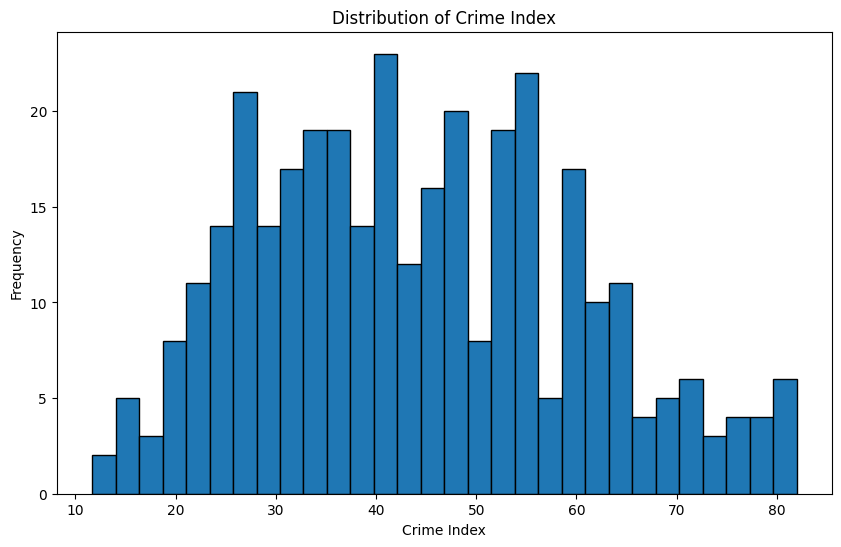

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Crime Index'], bins=30, edgecolor='black')
plt.title('Distribution of Crime Index')
plt.xlabel('Crime Index')
plt.ylabel('Frequency')
plt.show()

Correlation Heatmap

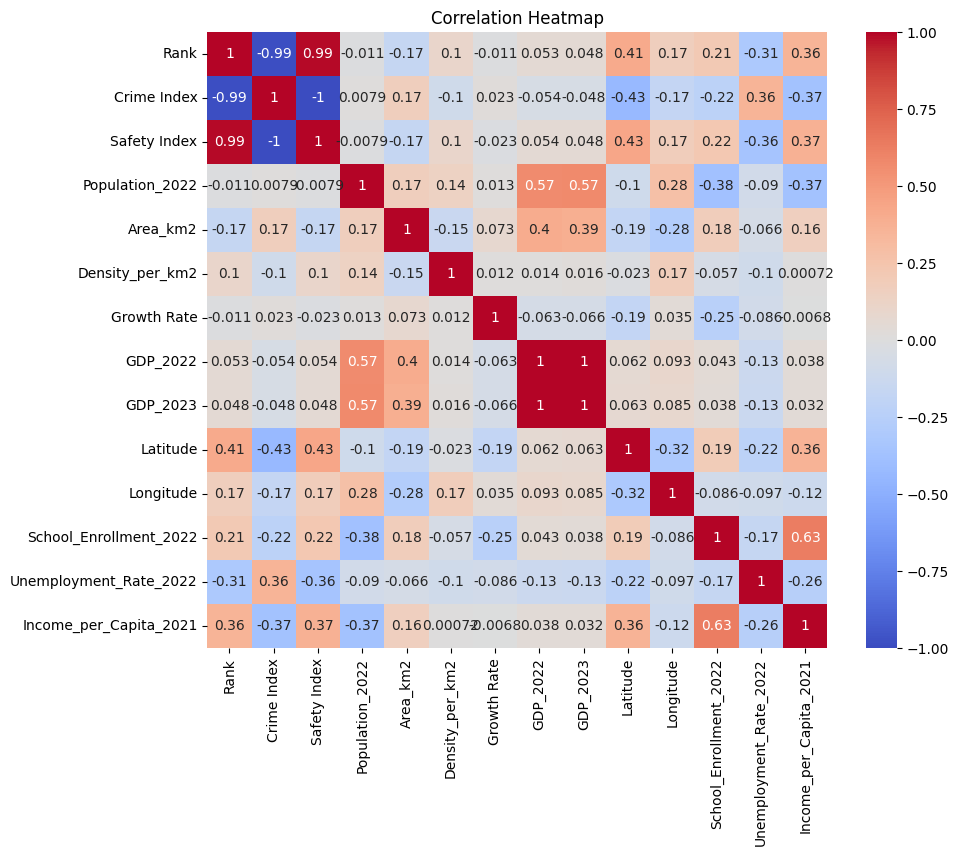

In [32]:
numeric_data = merged_data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Bar chart: Top 10 Highest and Lowest Crime Indices

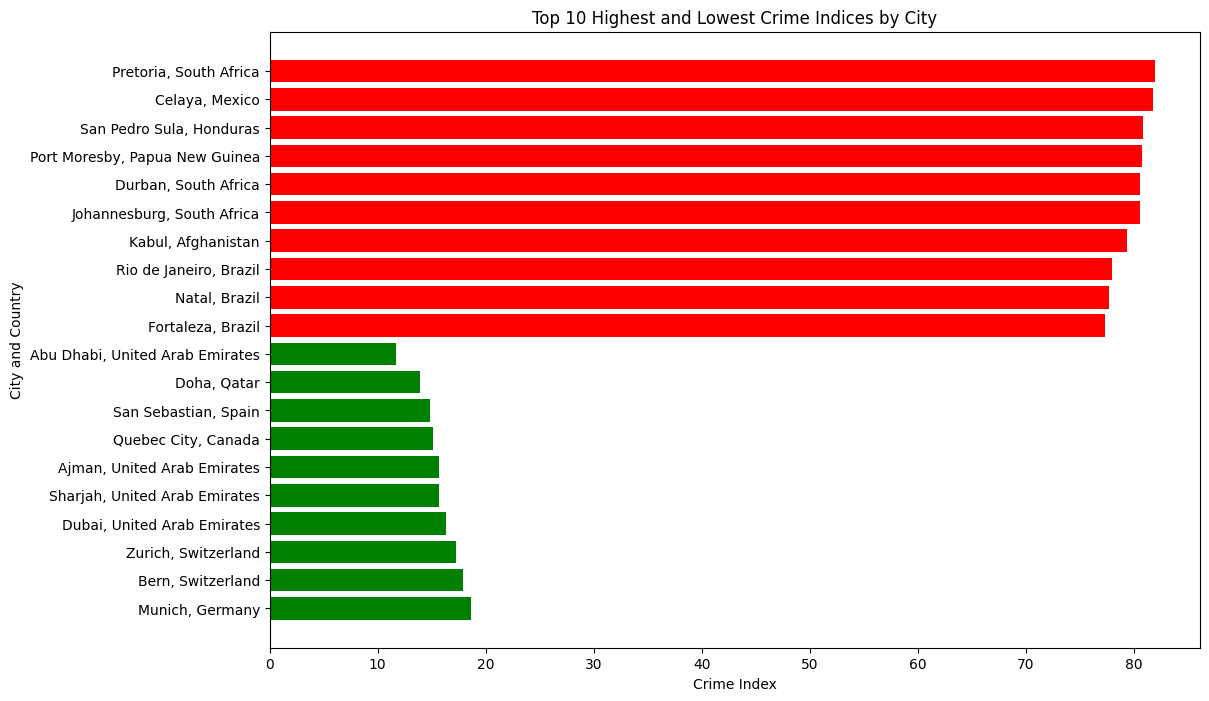

In [34]:
top_bottom_crime = pd.concat([merged_data.nlargest(10, 'Crime Index'), merged_data.nsmallest(10, 'Crime Index')])

plt.figure(figsize=(12, 8))
plt.barh(top_bottom_crime['City_Country'], top_bottom_crime['Crime Index'],
         color=['red' if x in merged_data.nlargest(10, 'Crime Index')['Crime Index'].values else 'green' for x in top_bottom_crime['Crime Index']])
plt.xlabel('Crime Index')
plt.ylabel('City and Country')
plt.title('Top 10 Highest and Lowest Crime Indices by City')
plt.gca().invert_yaxis()
plt.show()

Correlation Matrix Heatmap

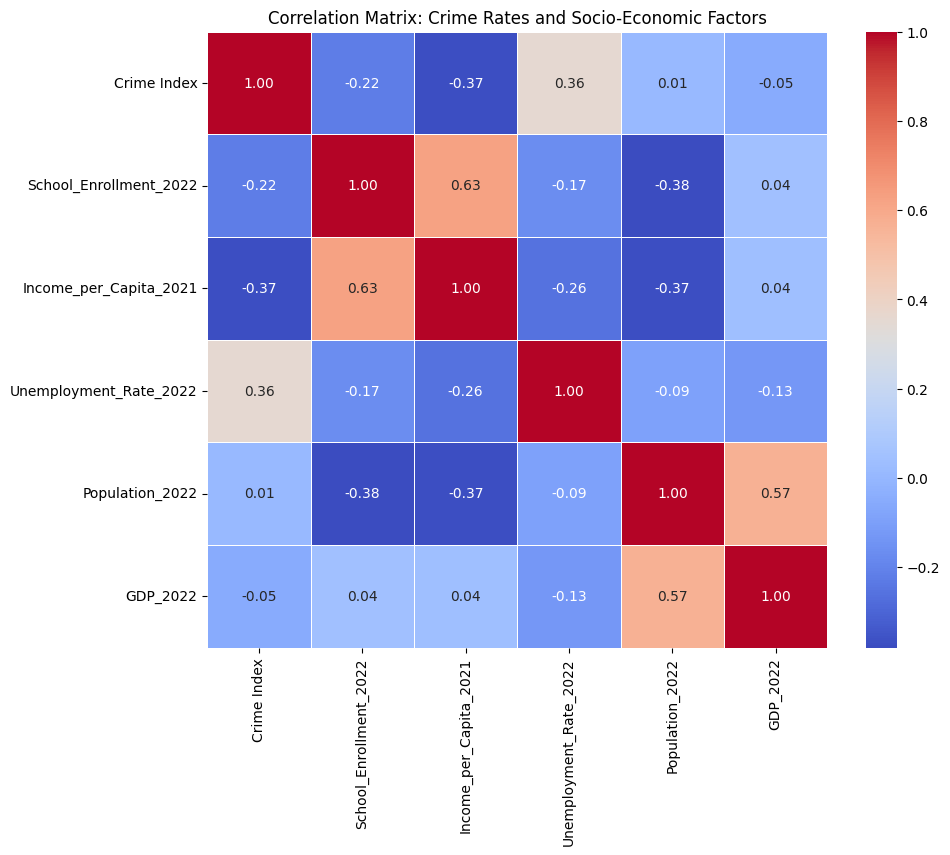

In [35]:
correlation_data = merged_data[['Crime Index', 'School_Enrollment_2022', 'Income_per_Capita_2021', 'Unemployment_Rate_2022', 'Population_2022', 'GDP_2022']]
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Crime Rates and Socio-Economic Factors')
plt.show()

Crime Index vs Income per Capita

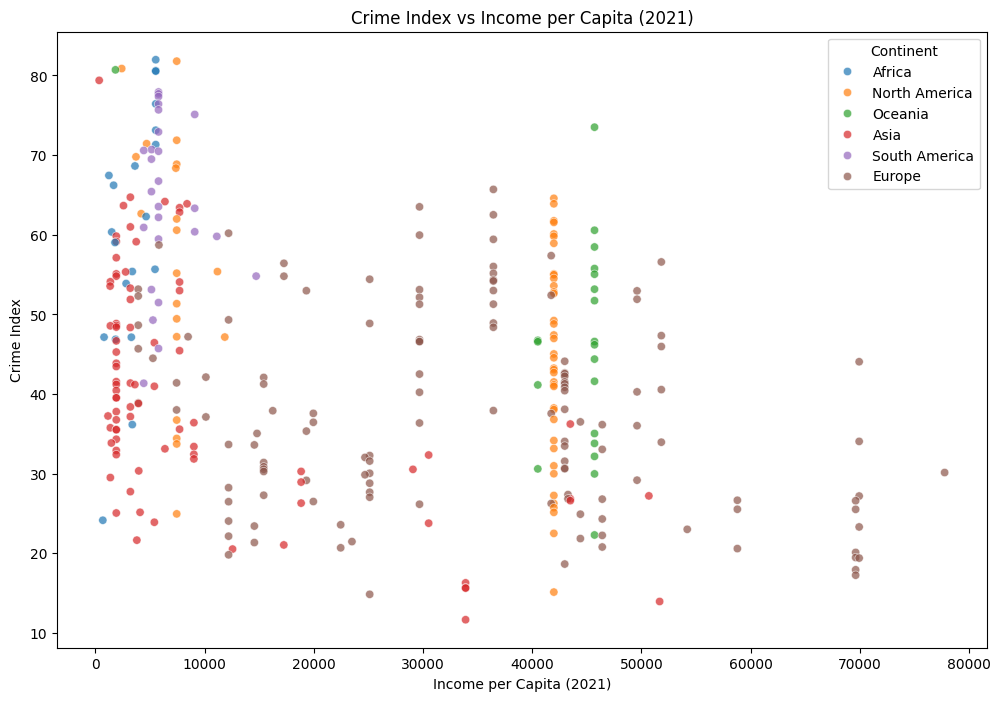

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data, x='Income_per_Capita_2021', y='Crime Index', hue='Continent_x', alpha=0.7)
plt.title('Crime Index vs Income per Capita (2021)')
plt.xlabel('Income per Capita (2021)')
plt.ylabel('Crime Index')
plt.legend(title='Continent')
plt.show()

Crime Index vs School Enrollment Rates

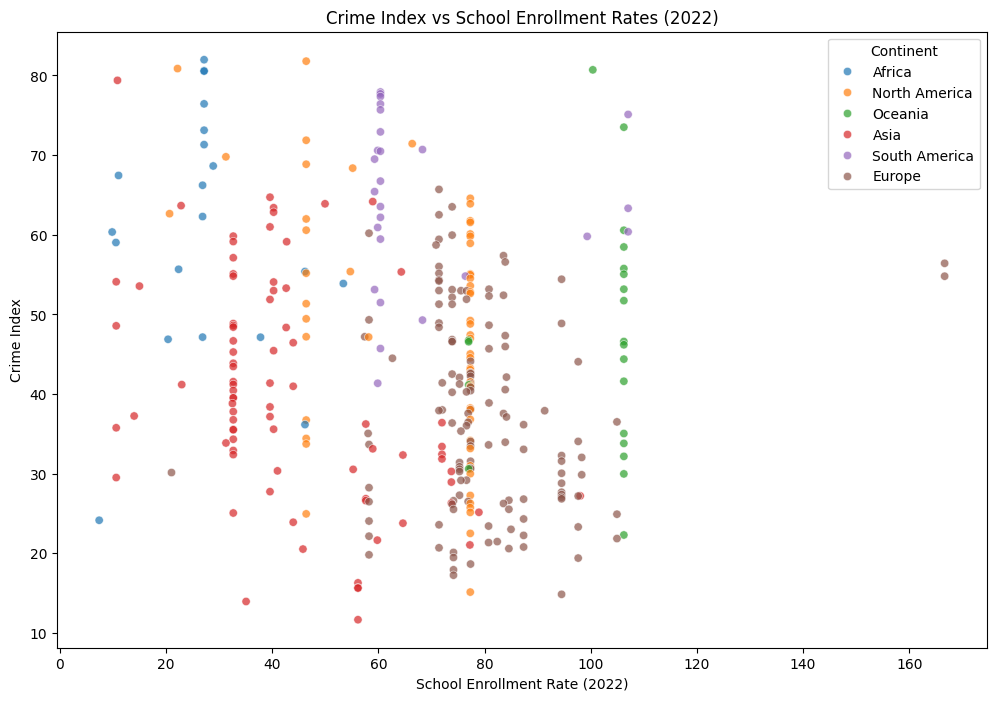

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data, x='School_Enrollment_2022', y='Crime Index', hue='Continent_x', alpha=0.7)
plt.title('Crime Index vs School Enrollment Rates (2022)')
plt.xlabel('School Enrollment Rate (2022)')
plt.ylabel('Crime Index')
plt.legend(title='Continent')
plt.show()

# Folium Interactive Map

In [39]:
import folium
from folium.plugins import MarkerCluster

# Function to determine marker color based on crime index
def get_color(crime_index):
    if crime_index < 20:
        return 'darkgreen'  # Very Low crime
    elif 20 <= crime_index < 40:
        return 'green'  # Low crime
    elif 40 <= crime_index < 60:
        return 'orange'  # Moderate crime
    elif 60 <= crime_index < 80:
        return 'red'  # High crime
    else:
        return 'darkred'  # Very High crime


crime_map = folium.Map(location=[20, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(crime_map)

# Add markers with colors
for _, row in merged_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        color=get_color(row['Crime Index']),
        fill=True,
        fill_color=get_color(row['Crime Index']),
        fill_opacity=0.7,
        popup=f"{row['City_Country']}<br>Crime Index: {row['Crime Index']}"
    ).add_to(marker_cluster)


crime_map
